In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import scipy.stats as stats
from sklearn.metrics import confusion_matrix
import sys,time
sys.path.insert(1, '../discrete_mixflows/')
from discrete_mixflows import *
from gibbs import *
from concrete import *

plt.rcParams.update({'figure.max_open_warning': 0})
plt.rcParams["figure.figsize"]=15,7.5
plt.rcParams.update({'font.size': 24})

In [2]:
# data generation
np.random.seed(2023)
N=1000
K=3
true_mu=np.array([-7.5,0,7.5])
true_tau=np.ones(3)
true_w=np.array([0.2,0.5,0.3])

x=np.random.choice(np.arange(K,dtype=int),size=N,p=true_w)
y=true_mu[x]+np.random.randn(N)/np.sqrt(true_tau[x])

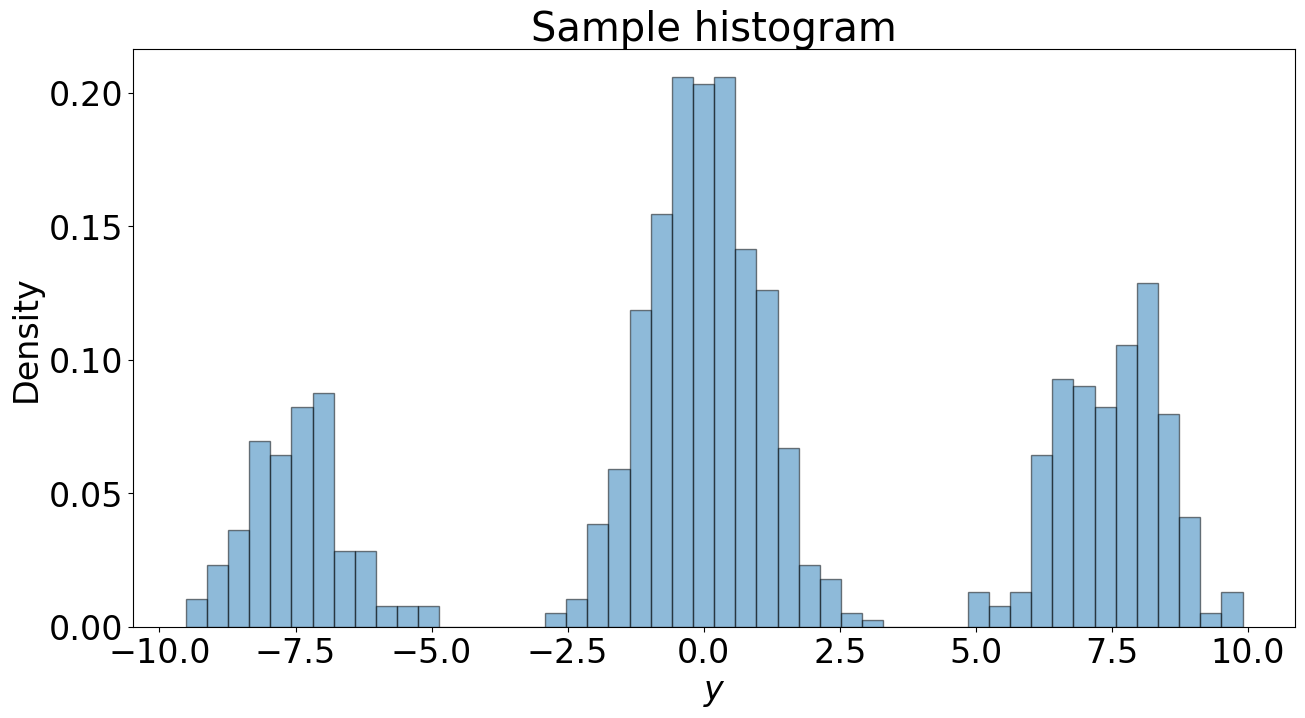

In [3]:
plt.hist(y,bins=50,alpha=0.5,ec='black',density=True)
plt.xlabel(r'$y$')
plt.ylabel('Density')
plt.title('Sample histogram');

In [4]:
# gibbs sampler
def gibbs_gmm(y,w,tau,tau0,steps,burnin_pct=0.25,verbose=False,seed=0):
    np.random.seed(0+seed)
    N=y.shape[0]
    K=w.shape[0]
    burnin_steps=int(steps*burnin_pct/(1-burnin_pct))
    
    # generate initial values
    x=np.random.randint(low=0,high=K,size=N)
    mu=np.random.randn(K)/np.sqrt(tau0)
    if steps==0: return x,mu
    
    # do burn-in pass
    for t in range(burnin_steps):
        if verbose: print('Burn-in: '+str(t+1)+'/'+str(burnin_steps),end='\r')
        #print(x.shape,mu.shape)
        x,mu=gibbs_gmm_update(x,mu,y,w,tau,tau0)
    # end for
    
    # do sampling pass
    xs=np.zeros((N,steps+1),dtype=int)
    xs[:,0]=x
    mus=np.zeros((K,steps+1))
    mus[:,0]=mu
    for t in range(steps):
        if verbose: print('Sampling: '+str(t+1)+'/'+str(steps),end='\r')
        tmpx,tmpmu=gibbs_gmm_update(xs[:,t],mus[:,t],y,w,tau,tau0)
        xs[:,t+1]=tmpx
        mus[:,t+1]=tmpmu
    # end for
    
    # sort according to latest mu
    sort_idx=np.argsort(mus[:,-1])
    mus=mus[sort_idx,:]
    xsc=np.zeros(xs.shape)
    for k in range(K): xsc[xs==k]=sort_idx[k]
    
    return xsc[:,1:],mus[:,1:]


def gibbs_gmm_update(x,mu,y,w,tau,tau0):
    N=x.shape[0]
    K=w.shape[0]
    
    # update x probs
    x_probs=w[np.newaxis,:]*np.exp(gauss_lp_allmeans(y,mu,tau))
    x_probs[x_probs<1e-32]=1e-32
    x_probs=x_probs/np.sum(x_probs,axis=1)[:,np.newaxis]
    
    # sample x via direct inversion (to avoid for loops or np.random.choice)
    Fx=np.cumsum(x_probs,axis=1)
    u=np.random.rand(N,1)
    x_=np.argmax(Fx>u,axis=1)
    
    # sample mu
    idx=(x_==np.arange(0,K,dtype=int)[:,np.newaxis])
    N_pool=np.sum(idx,axis=1)
    tau_pool=N_pool+tau0
    y_pool=np.sum(y*idx,axis=1)/tau_pool
    mu_=y_pool+np.random.randn(K)/np.sqrt(tau_pool)
    
    return x_,mu_
    
    
def gauss_lp_allmeans(y,mu,tau): #(N,),(K,),(K,)->(N,K)
    return -0.5*((y[:,np.newaxis]-mu[np.newaxis,:])**2)*tau[np.newaxis,:]-0.5*np.log(2*np.pi/tau[np.newaxis,:])

In [5]:
tau0=0.1
steps=1000
pred_x,pred_mu=gibbs_gmm(y,true_w,true_tau,tau0,steps,burnin_pct=0.9,verbose=True,seed=2023)

In [6]:
print(pred_mu[:,-1])

[-7.50242805  0.03012793  7.38762525]


In [7]:
confusion_matrix(x,pred_x[:,-1])

array([[176,   0,   0],
       [  0, 538,   0],
       [  0,   0, 286]])